## 3. Comparison and policy exploration ##

In notebook "1_open_exploration_base_case" the scenario space was explored under the 'base case' policy. In this notebook the policy space IS explored by running 100 random policies for random 500 scenarios and the results with the 'base case' policy are compared to examine if any policy implementation improves the outcomes.

With the retrieved "outcomes_combined" dataframe containing the outcomes from both runs, the variables are aggregated in order to visualize them and compare them to each other. The aggregation is done with the aggregate function 'aggregate_kpi' created in "aggragation_function.py" 

The result of the scenario discovery done in this notebook is reported and analyzed in section 4.3 of the report.

### 0. Inporting Libraries

In [22]:
# Import libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Import workbench libraries
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import pairs_plotting, plotting
from ema_workbench.util import ema_logging, utilities
from ema_workbench import save_results
from ema_workbench import load_results

# Import dike model 
from problem_formulation_new import get_model_for_problem_formulation
from dike_model_function import DikeNetwork 

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 1. Data Loading and Transformation ###

In [23]:
# # Commented out because the experiments are run just once in the begging and then loaded

# # Import case function
# # Choose problem formulation number, between 0-5
# dike_model, planning_steps = get_model_for_problem_formulation(5)

# def sum_over(*args):
#     return sum(args)

# #Running the experiments
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=500, policies=100)

# # Saving results
# utilities.save_results(results, 'results/500_scenarios_100_policies.csv')

# Load in the results, for both the with and the without policy runs.
experiments, outcomes = utilities.load_results('results/500_scenarios_100_policies.csv')
experiments_base, outcomes_base = utilities.load_results('results/5000_scenarios_base_case.csv')

# Transform the outcomes to a dataframe.
df_outcomes = pd.DataFrame(outcomes)
df_outcomes_base = pd.DataFrame(outcomes_base)

# Merge the seperate dataframes into one.
experiments_combined = pd.concat([experiments, experiments_base], sort = True)
outcomes_combined = pd.concat([df_outcomes, df_outcomes_base], sort = True)

# Rename all the runs that include policy to "random" (indicating random policies), and all the others keep their original name of 'base case'
experiments_combined.loc[experiments_combined["policy"] != "base case", "policy"] = "random"

# And add them to a column within the combined outcomes dataframe
policies = experiments_combined["policy"]
outcomes_combined["policy"] = policies

[MainProcess/INFO] results loaded succesfully from C:\Users\ASUS\PycharmProjects\EPA1361\EPA1361_final\results\500_scenarios_100_policies.csv
[MainProcess/INFO] results loaded succesfully from C:\Users\ASUS\PycharmProjects\EPA1361\EPA1361_final\results\5000_scenarios_base_case.csv


In [24]:
# Importing aggragation_function used to aggregate the outcomes into the KPI we want.
# This iterates over all the locations and round numbers, and creates a new column summing the values per location and round.
# If we want to aggregate over the location, "aggregate" equals "location" and therefore the KPI is added per location and not in total.
# If we want to aggregate over the province, "aggregate" equals "province" and therefore the KPI is added per province.
# On the contrary, if aggregate equals "total", the total value is appended to the dataframe.
from aggragation_function import aggregate_kpi

# Append the KPIs we would like to analyse.
outcomes_combined = outcomes_combined.reset_index(drop=True)
outcomes_combined = aggregate_kpi(outcomes_combined, "Expected Number of Deaths", "province")
outcomes_combined = aggregate_kpi(outcomes_combined, "Expected Annual Damage", "province")
outcomes_combined = aggregate_kpi(outcomes_combined, "Dike Investment Costs", "province")
outcomes_combined = aggregate_kpi(outcomes_combined, "RfR Total Costs", "total")
outcomes_combined = aggregate_kpi(outcomes_combined, "Expected Evacuation Costs", "total")

In [25]:
outcomes_combined.head()

,A.1_Dike Investment Costs 0,A.1_Dike Investment Costs 1,A.1_Dike Investment Costs 2,A.1_Expected Annual Damage 0,A.1_Expected Annual Damage 1,A.1_Expected Annual Damage 2,A.1_Expected Number of Deaths 0,A.1_Expected Number of Deaths 1,A.1_Expected Number of Deaths 2,A.2_Dike Investment Costs 0,...,RfR Total Costs 2,policy,Overijssel_Expected Number of Deaths,Gelderland_Expected Number of Deaths,Overijssel_Expected Annual Damage,Gelderland_Expected Annual Damage,Overijssel_Dike Investment Costs,Gelderland_Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs
0,9.510733e+07,1.067683e+08,0,0.0,0.0,0.0,0.0,0.0,0.0,5.335857e+07,...,121200000.0,random,0.000000,0.000580,0.000000e+00,5.277757e+06,1.456524e+08,5.690858e+08,710400000.0,171.567079
1,9.510733e+07,1.067683e+08,0,0.0,0.0,0.0,0.0,0.0,0.0,5.335857e+07,...,121200000.0,random,0.003173,0.000586,2.027169e+07,3.261020e+06,1.456524e+08,5.690858e+08,710400000.0,1345.966416
2,9.510733e+07,1.067683e+08,0,0.0,0.0,0.0,0.0,0.0,0.0,5.335857e+07,...,121200000.0,random,0.000094,0.000000,1.511530e+06,0.000000e+00,1.456524e+08,5.690858e+08,710400000.0,60.019692
3,9.510733e+07,1.067683e+08,0,0.0,0.0,0.0,0.0,0.0,0.0,5.335857e+07,...,121200000.0,random,0.000000,0.000000,0.000000e+00,0.000000e+00,1.456524e+08,5.690858e+08,710400000.0,0.000000
4,9.510733e+07,1.067683e+08,0,0.0,0.0,0.0,0.0,0.0,0.0,5.335857e+07,...,121200000.0,random,0.001507,0.006280,9.106152e+06,2.067275e+07,1.456524e+08,5.690858e+08,710400000.0,1405.596354


In [26]:
# crating data frame with outcome of interest
df_ooi = outcomes_combined[["policy", 
                            "Overijssel_Expected Number of Deaths", 
                            "Gelderland_Expected Number of Deaths",
                            'Overijssel_Expected Annual Damage',
                            'Gelderland_Expected Annual Damage',
                            'Overijssel_Dike Investment Costs',
                            'Gelderland_Dike Investment Costs',
                            'RfR Total Costs',
                            'Expected Evacuation Costs']]


In [27]:
# add column for the total policy cost
df_ooi["Total Policy Costs"] = df_ooi.loc[:, ("RfR Total Costs",
                                              "Expected Evacuation Costs",
                                              "Gelderland_Dike Investment Costs",
                                              "Overijssel_Dike Investment Costs")].sum(axis=1)

df_ooi.head()

C:\Users\ASUS\miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,policy,Overijssel_Expected Number of Deaths,Gelderland_Expected Number of Deaths,Overijssel_Expected Annual Damage,Gelderland_Expected Annual Damage,Overijssel_Dike Investment Costs,Gelderland_Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs,Total Policy Costs
0,random,0.000000,0.000580,0.000000e+00,5.277757e+06,1.456524e+08,5.690858e+08,710400000.0,171.567079,1.425138e+09
1,random,0.003173,0.000586,2.027169e+07,3.261020e+06,1.456524e+08,5.690858e+08,710400000.0,1345.966416,1.425140e+09
2,random,0.000094,0.000000,1.511530e+06,0.000000e+00,1.456524e+08,5.690858e+08,710400000.0,60.019692,1.425138e+09
3,random,0.000000,0.000000,0.000000e+00,0.000000e+00,1.456524e+08,5.690858e+08,710400000.0,0.000000,1.425138e+09
4,random,0.001507,0.006280,9.106152e+06,2.067275e+07,1.456524e+08,5.690858e+08,710400000.0,1405.596354,1.425140e+09


### Visualization ###

For df_ooi dataframe the following KPIs are visualized:

 - Expected Number of Deaths
 - Overijssel_Expected Annual Damage
 - Gelderland_Expected Annual Damage
 - Total Policy Costs

The results show that any given policy will drastically decrease the negative outcomes of the flooding.

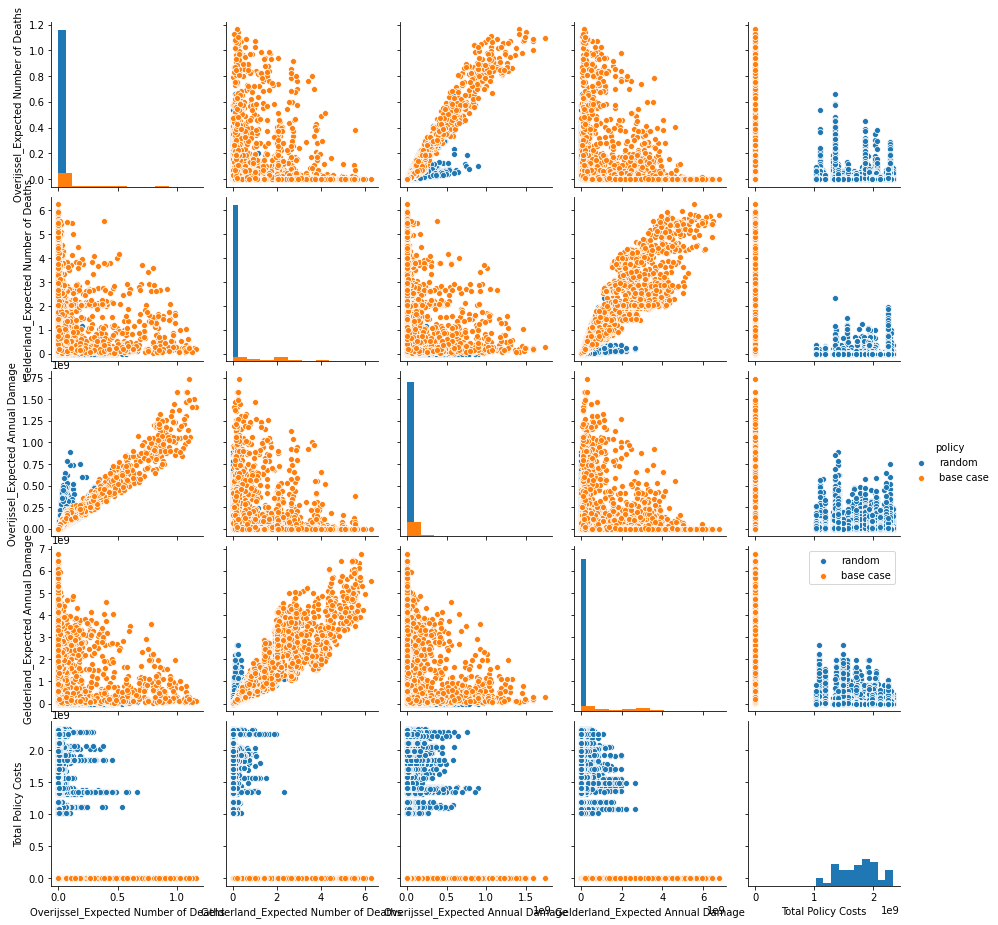

In [28]:
#Now that a combined dataframe has been created, plotting the base case against the random policy runs
sns.pairplot(df_ooi, hue='policy', hue_order=["random", "base case"], vars=["Overijssel_Expected Number of Deaths", 
                                                                            "Gelderland_Expected Number of Deaths",
                                                                            'Overijssel_Expected Annual Damage',
                                                                            'Gelderland_Expected Annual Damage', 
                                                                            'Total Policy Costs'], diag_kind="hist")
plt.legend()
# Saving image
plt.savefig("images/comparison_pairplot.png")
plt.show()

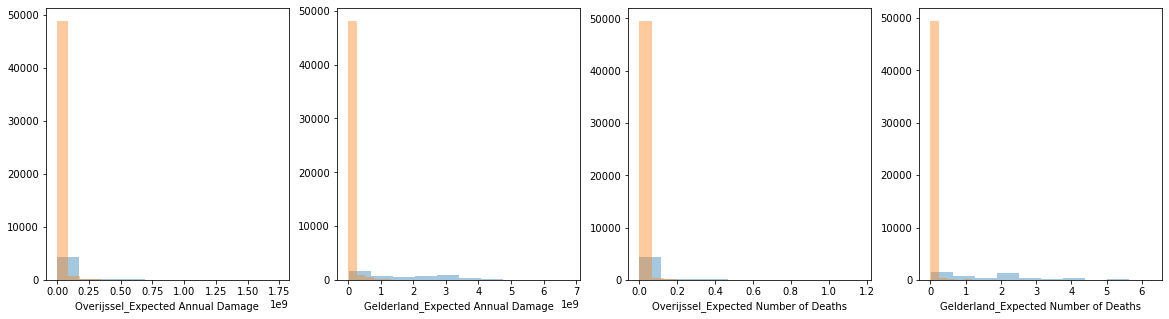

In [29]:
#Create 4 histograms for the 4 KPI's, in which base case is plotted against random policies.
f, axes = plt.subplots(1, 4, figsize=(20,5))

sns.distplot(df_ooi.loc[df_ooi["policy"] == "base case", "Overijssel_Expected Annual Damage"],
                                                            kde=False, bins=10, label='Base case', ax=axes[0])
sns.distplot(df_ooi.loc[df_ooi["policy"] == "random", "Overijssel_Expected Annual Damage"],
                                                            kde=False, bins=10, label='Policy', ax=axes[0])

sns.distplot(df_ooi.loc[df_ooi["policy"] == "base case", "Gelderland_Expected Annual Damage"],
                                                            kde=False, bins=10, label='Base case', ax=axes[1])
sns.distplot(df_ooi.loc[df_ooi["policy"] == "random", "Gelderland_Expected Annual Damage"],
                                                            kde=False, bins=10, label='Policy', ax=axes[1])

sns.distplot(df_ooi.loc[df_ooi["policy"] == "base case", "Overijssel_Expected Number of Deaths"],
                                                            kde=False, bins=10, label='Base case', ax=axes[2])
sns.distplot(df_ooi.loc[df_ooi["policy"] == "random", "Overijssel_Expected Number of Deaths"],  
                                                             kde=False, bins=10, label='Policy', ax=axes[2])

sns.distplot(df_ooi.loc[df_ooi["policy"] == "base case", "Gelderland_Expected Number of Deaths"],
                                                            kde=False, bins=10, label='Base case', ax=axes[3])
sns.distplot(df_ooi.loc[df_ooi["policy"] == "random", "Gelderland_Expected Number of Deaths"],  
                                                             kde=False, bins=10, label='Policy', ax=axes[3])

plt.savefig("images/comparison_displot.png")

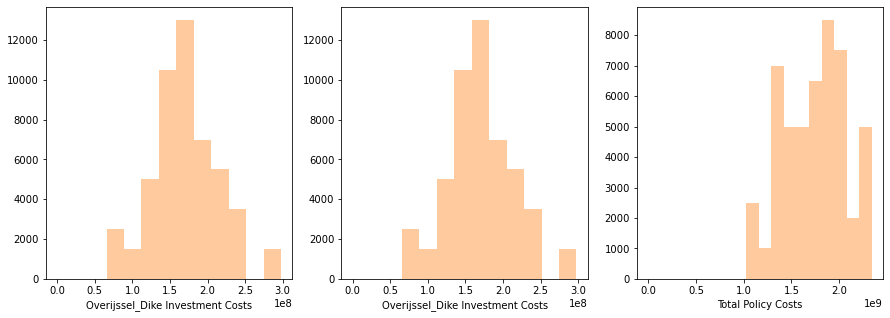

In [30]:
#Create 3 histograms for the 3 KPI's, to ahow the dike cost per province and the total policy cost in general.
f, axes = plt.subplots(1, 3, figsize=(15,5))

sns.distplot(df_ooi.loc[df_ooi["policy"] == "base case", "Overijssel_Dike Investment Costs"], 
                                             kde=False, bins=10, label='Base case', ax=axes[0])
sns.distplot(df_ooi.loc[df_ooi["policy"] == "random", "Overijssel_Dike Investment Costs"], 
                                             kde=False, bins=10, label='Policy', ax=axes[0])

sns.distplot(df_ooi.loc[df_ooi["policy"] == "base case", "Overijssel_Dike Investment Costs"],  
                                             kde=False, bins=10, label='Base case', ax=axes[1])
sns.distplot(df_ooi.loc[df_ooi["policy"] == "random", "Overijssel_Dike Investment Costs"], 
                                             kde=False, bins=10, label='Policy', ax=axes[1])

sns.distplot(df_ooi.loc[df_ooi["policy"] == "base case", "Total Policy Costs"],  
                                             kde=False, bins=10, label='Base case', ax=axes[2])
sns.distplot(df_ooi.loc[df_ooi["policy"] == "random", "Total Policy Costs"],  
                                             kde=False, bins=10, label='Policy', ax=axes[2])

plt.savefig("images/cost_displot.png")

In [31]:
#Overview of the maximum, mean and standard deviation values of the KPI's, comparing policy to base case.
from decimal import Decimal
print("Base case vs. with policy: \n",
      
       "Maximum expected annual damage Overijssel: \t\t\t\t", 
      '%.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "base case", "Overijssel_Expected Annual Damage"].max()), 
       '\t\t %.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "random", "Overijssel_Expected Annual Damage"].max()),
      
       "\n Maximum expected annual damage Gelderland: \t\t\t\t", 
      '%.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "base case", "Gelderland_Expected Annual Damage"].max()), 
       '\t\t %.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "random", "Gelderland_Expected Annual Damage"].max()),
      
      "\n Maximum expected number of deaths Overijssel: \t\t\t\t", 
      df_ooi.loc[df_ooi["policy"] == "base case", "Overijssel_Expected Number of Deaths"].max(), 
      '\t', df_ooi.loc[df_ooi["policy"] == "random", "Overijssel_Expected Number of Deaths"].max(),  
      
       "\n Maximum expected number of deaths Gelderland: \t\t\t\t", 
      df_ooi.loc[df_ooi["policy"] == "base case", "Gelderland_Expected Number of Deaths"].max(), 
      '\t', df_ooi.loc[df_ooi["policy"] == "random", "Gelderland_Expected Number of Deaths"].max(),
      
       "\n Maximum policy costs: \t\t\t\t\t\t\t", 
      df_ooi.loc[df_ooi["policy"] == "base case", "Total Policy Costs"].max(), 
      '\t\t\t', '%.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "random", "Total Policy Costs"].max()),
      
      
      "\n\n Average expected annual damage Overijssel: \t\t\t\t", 
      '%.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "base case", "Overijssel_Expected Annual Damage"].mean()), 
      '\t\t %.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "random","Overijssel_Expected Annual Damage"].mean()),
      
       "\n Average expected annual damage Gelderland: \t\t\t\t", 
      '%.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "base case", "Gelderland_Expected Annual Damage"].mean()), 
      '\t\t %.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "random", "Gelderland_Expected Annual Damage"].mean()),
      
      "\n Average expected number of deaths Overijssel: \t\t\t\t", 
      df_ooi.loc[df_ooi["policy"] == "base case", "Overijssel_Expected Number of Deaths"].mean(), 
      '\t', df_ooi.loc[df_ooi["policy"] == "random", "Overijssel_Expected Number of Deaths"].mean(),
      
      "\n Average expected number of deaths Gelderland : \t\t\t", 
      df_ooi.loc[df_ooi["policy"] == "base case", "Gelderland_Expected Number of Deaths"].mean(), 
      '\t', df_ooi.loc[df_ooi["policy"] == "random", "Gelderland_Expected Number of Deaths"].mean(), 

      "\n Average policy costs: \t\t\t\t\t\t\t", 
      df_ooi.loc[df_ooi["policy"] == "base case", "Total Policy Costs"].mean(), 
      '\t\t\t', '%.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "random", "Total Policy Costs"].mean()),
      
      
      "\n\n Standard deviation average expected annual damage Overijssel: \t\t", 
      '%.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "base case", "Overijssel_Expected Annual Damage"].std()), 
      '\t\t %.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "random", "Overijssel_Expected Annual Damage"].std()), 
      
        "\n Standard deviation average expected annual damage Gelderland: \t\t", 
      '%.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "base case", "Gelderland_Expected Annual Damage"].std()), 
      '\t\t %.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "random", "Gelderland_Expected Annual Damage"].std()),      
      
        "\n Standard deviation expected number of deaths Overijssel: \t\t", 
      df_ooi.loc[df_ooi["policy"] == "base case", "Overijssel_Expected Number of Deaths"].std(),'\t',
       df_ooi.loc[df_ooi["policy"] == "random", "Overijssel_Expected Number of Deaths"].std(), 
      
        "\n Standard deviation expected number of deaths Gelderland: \t\t", 
      df_ooi.loc[df_ooi["policy"] == "base case", "Gelderland_Expected Number of Deaths"].std(),'\t',
       df_ooi.loc[df_ooi["policy"] == "random", "Gelderland_Expected Number of Deaths"].std(), 
      
      "\n Standard deviation policy costs: \t\t\t\t\t", 
      df_ooi.loc[df_ooi["policy"] == "base case", "Total Policy Costs"].std(), 
      '\t\t\t', '%.2E' % Decimal(df_ooi.loc[df_ooi["policy"] == "random", "Total Policy Costs"].std())
    
    
      
     )


Base case vs. with policy: 
 Maximum expected annual damage Overijssel: 				 1.74E+09 		 8.92E+08 
 Maximum expected annual damage Gelderland: 				 6.78E+09 		 2.65E+09 
 Maximum expected number of deaths Overijssel: 				 1.1646689511931045 	 0.6589961467584576 
 Maximum expected number of deaths Gelderland: 				 6.259332966518987 	 2.3472107779921125 
 Maximum policy costs: 							 0.0 			 2.34E+09 

 Average expected annual damage Overijssel: 				 8.51E+07 		 9.99E+06 
 Average expected annual damage Gelderland: 				 1.76E+09 		 3.66E+07 
 Average expected number of deaths Overijssel: 				 0.06741008599087425 	 0.003438580852382025 
 Average expected number of deaths Gelderland : 			 1.6984583838941147 	 0.013599162884879277 
 Average policy costs: 							 0.0 			 1.75E+09 

 Standard deviation average expected annual damage Overijssel: 		 2.06E+08 		 3.50E+07 
 Standard deviation average expected annual damage Gelderland: 		 1.37E+09 		 1.40E+08 
 Standard deviation expected number 